# Executive Exploratory Data Analysis

## Georgia Tech MSA Spring 2026 Practicum

This is your EDA Executive Summary. Fill in the details of your analysis here.

### Executive Summary

- The initial research question was "How do market odds shift after big events like goals and red cards and how do these shifts compare to the statistical impact of the events?" Unfortunately, after data integrity checks and exploration, it was concluded that the datasets are not sufficient to support a comprehensive analysis of this question. 

- The revised research question is "Can we categorize soccer team identities into distinct Styles of Play using event-level passing data and spacial distributions?"

- This analysis uses soccer event data from Statsbomb across 3,464 matches.

- Initial EDA proved statistically significant differences in passing attributes between teams. Using pass by pass events data from Statsbomb, a match by match Play Style vector can be developed. 

- The next steps of analysis will follow Track 2 Soccer Analytics Dashboard Exploration.

- Unsupervised learning and clustering of the match play style vectors will be used to determine tactical clusters. These clusters can be used to explore play styles and success across different seasons, leagues, and opponents.

- A dashboard will be deployed to Streamlit to visualize play styles using radar charts and heat maps. This could potentially be used by clubs to benchmark their tactical consistency against professional archetypes.


### Data Retrieval

The analysis started with 2 distinct datasets:
- Statsbomb soccer events and 360 data
- Polymarket soccer odds data

There is some minor preprocessing required with dates and times to correct a timestamp corruption issue and align data with UTC.

In [3]:
from pathlib import Path

polymarket_directory = Path("../data/Polymarket")
statsbomb_directory = Path("../data/Statsbomb")

In [4]:
import polars as pl

def load_matches():
    # Load match data from Statsbomb.
    matches = pl.read_parquet(statsbomb_directory / "matches.parquet")

    # Calculate the UTC kickoff time
    matches = matches.with_columns(
        pl.format("{} {}", pl.col("match_date"), pl.col("kickoff"))
        .str.to_datetime("%Y-%m-%d %H:%M:%S")
        .alias("kickoff_utc")
    )

    return matches

matches = load_matches()

def events_to_utc(matches_df):
    # Use kickoff time to convert event timestamps to UTC
    events = pl.read_parquet(statsbomb_directory / "events.parquet")

    events = events.join(matches_df, on="match_id", how="left").with_columns(
        (pl.col("kickoff_utc") + pl.duration(minutes="minute", seconds="second")).alias("event_time_utc")
    )

    return events

events = events_to_utc(matches)

In [5]:
# Load odds history data from Polymarket and convert timestamps to datetime format

def load_all_odds():
    return (
        pl.scan_parquet(polymarket_directory / "soccer_odds_history.parquet")
        .with_columns(pl.col("timestamp").cast(pl.Int64).cast(pl.Datetime("ms")))
        .collect()
    )

odds_history = load_all_odds()
markets = pl.read_parquet(polymarket_directory / "soccer_markets.parquet")
tokens = pl.read_parquet(polymarket_directory / "soccer_tokens.parquet")

### General Dataset Overview (Original Research Question)

A key finding when exploring the original research question was a lack of sufficient overlap in the datasets. This was explored using histograms showing data frequency over time.

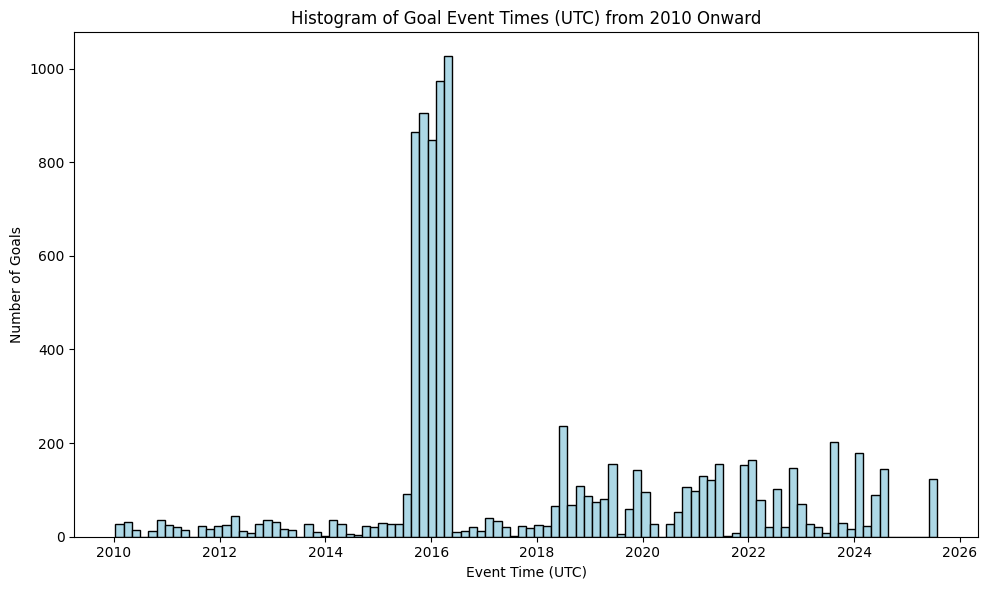

In [6]:
# Filter for goal events and select relevant columns
goals = events.filter((pl.col("type") == "Shot") & (pl.col("shot_outcome") == "Goal")).select(["match_id", "team", "shot_statsbomb_xg", "home_team", "away_team", "event_time_utc"])

# Plot a histogram of goal event times (UTC) to visualize density of data across the timeline

import matplotlib.pyplot as plt

goals_2010 = goals.filter(pl.col("event_time_utc") >= pl.datetime(2010, 1, 1))

event_times = goals_2010["event_time_utc"].to_pandas()

plt.figure(figsize=(10, 6))
plt.hist(event_times, bins=100, color='lightblue', edgecolor='black')
plt.xlabel('Event Time (UTC)')
plt.ylabel('Number of Goals')
plt.title('Histogram of Goal Event Times (UTC) from 2010 Onward')
plt.tight_layout()
plt.show()

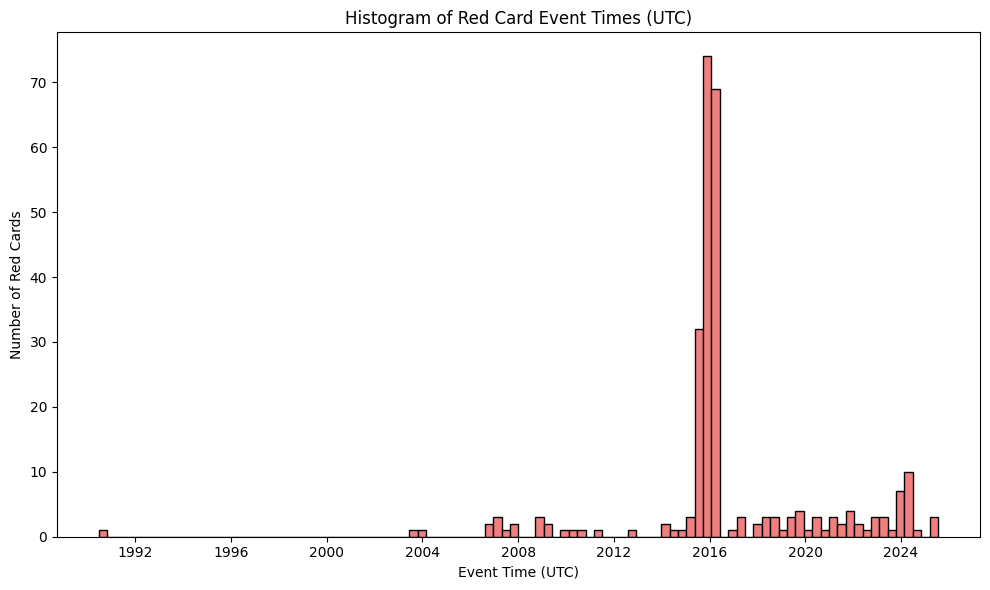

In [7]:
def load_red_cards():
    lineups = pl.read_parquet(statsbomb_directory / "lineups.parquet") # Get lineups data where red card info is stored

    red_cards = lineups.filter(pl.col("card_type") == "Red Card") # Filter for red cards only
    red_cards = red_cards.join(matches, on="match_id", how="left") # Join with matches to get kickoff time

    # Filter out rows where to_time is null where there is missing time info 
    red_cards = red_cards.filter(pl.col("to_time").is_not_null())

    # Split time into minutes and seconds to avoid errors with soccer match clock structure (no hours)
    red_cards = red_cards.with_columns(
        pl.col("to_time").str.split_exact(":", 1).alias("time_split")
    ).with_columns([
        pl.col("time_split").struct.field("field_0").cast(pl.Int64).alias("minutes"),
        pl.col("time_split").struct.field("field_1").cast(pl.Int64).alias("seconds")
    ])

    # Calculate red card time in UTC by adding minutes and seconds to kickoff time
    red_cards = red_cards.with_columns(
        (pl.col("kickoff_utc") + 
         pl.duration(minutes=pl.col("minutes"), seconds=pl.col("seconds"))
        ).alias("event_time_utc")
    )

    # Keep last record for each player to capture correct send off time
    red_cards = (red_cards.sort("event_time_utc").unique(subset=["match_id", "player_name"], keep="last")) 
    
    return red_cards.unique(subset=["match_id", "player_name"], keep="last").select([
    "match_id", 
    "team_name",     
    "home_team",    
    "away_team",     
    "player_name", 
    "event_time_utc"
])

red_cards = load_red_cards()

rc_times = red_cards["event_time_utc"].to_pandas()

plt.figure(figsize=(10, 6))
plt.hist(rc_times, bins=100, color='lightcoral', edgecolor='black')
plt.xlabel('Event Time (UTC)')
plt.ylabel('Number of Red Cards')
plt.title('Histogram of Red Card Event Times (UTC)')
plt.tight_layout()
plt.show()

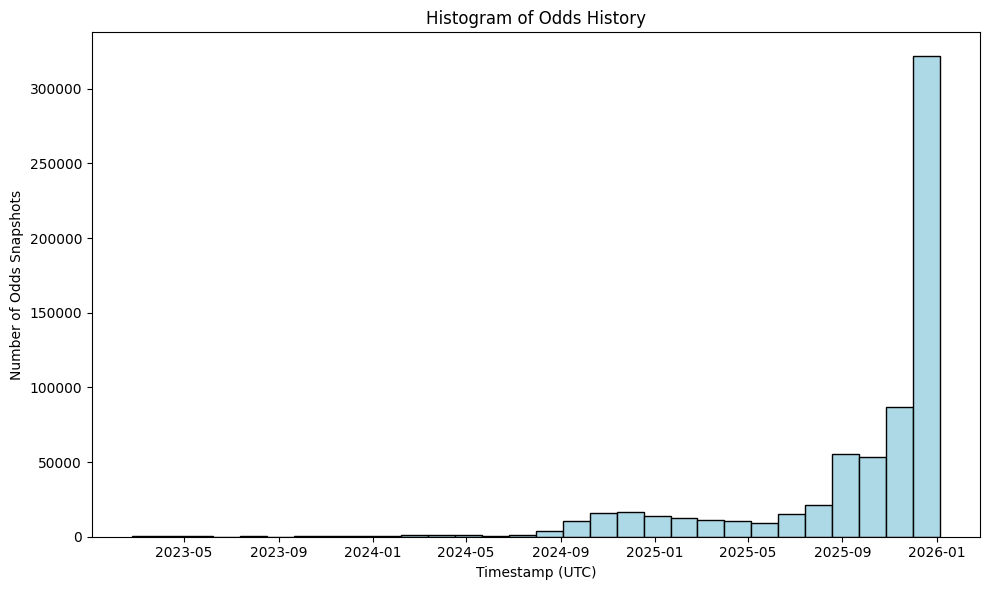

In [8]:
odds_history_plot = odds_history['timestamp'].to_pandas()

plt.figure(figsize=(10, 6))
plt.hist(odds_history_plot, bins=30, color='lightblue', edgecolor='black')
plt.xlabel('Timestamp (UTC)')
plt.ylabel('Number of Odds Snapshots')
plt.title('Histogram of Odds History')
plt.tight_layout()
plt.show()

As visualized in the histograms above, there is low overlap in the Statsbomb events data (goals and red cards) and the Polymarket odds data. Due to concerns that there may not be sufficient sample size for a statistically significant analysis, the project direction was revised to focus on a single dataset with a new research question.

### General Dataset Overview (Revised Research Question)

The revised project direction will look at events data from Statsbomb exclusively, without attempting to align with Polymarket data, to ensure sufficient sample size for analysis. The focus will be on analyzing the passing styles of teams in each match.

The first step was to identify passing features in the events data and generate general summary statistics for an understanding of the data types and scale.

In [9]:
# Select passing features for exploration
pass_features = events.filter(pl.col("type") == "Pass").select([
    "pass_length", "pass_angle", "pass_height", "pass_type", "pass_outcome", "pass_cross", "pass_switch", "pass_through_ball"
])

# Generate summary statistics to understand the data scale
print("Pass Attribute Summary")
with pl.Config(tbl_cols=-1):
    display(pass_features.describe())

Pass Attribute Summary


statistic,pass_length,pass_angle,pass_height,pass_type,pass_outcome,pass_cross,pass_switch,pass_through_ball
str,f64,f64,str,str,str,f64,f64,f64
"""count""",3.38776e6,3.38776e6,"""3387760""","""713056""","""754324""",3.38776e6,3.38776e6,3.38776e6
"""null_count""",0.0,0.0,"""0""","""2674704""","""2633436""",0.0,0.0,0.0
"""mean""",21.419777,0.009437,null,null,null,0.023759,0.028011,0.00505
"""std""",14.700637,1.524517,null,null,null,null,null,null
"""min""",0.0,-3.138768,"""Ground Pass""","""Corner""","""Incomplete""",0.0,0.0,0.0
"""25%""",11.335784,-1.145964,null,null,null,null,null,null
"""50%""",17.327723,0.0,null,null,null,null,null,null
"""75%""",27.018513,1.176005,null,null,null,null,null,null
"""max""",122.580788,3.141593,"""Low Pass""","""Throw-in""","""Unknown""",1.0,1.0,1.0


Plots were used to explore certain features and establish a better understanding for later feature engineering and play style interpretation.

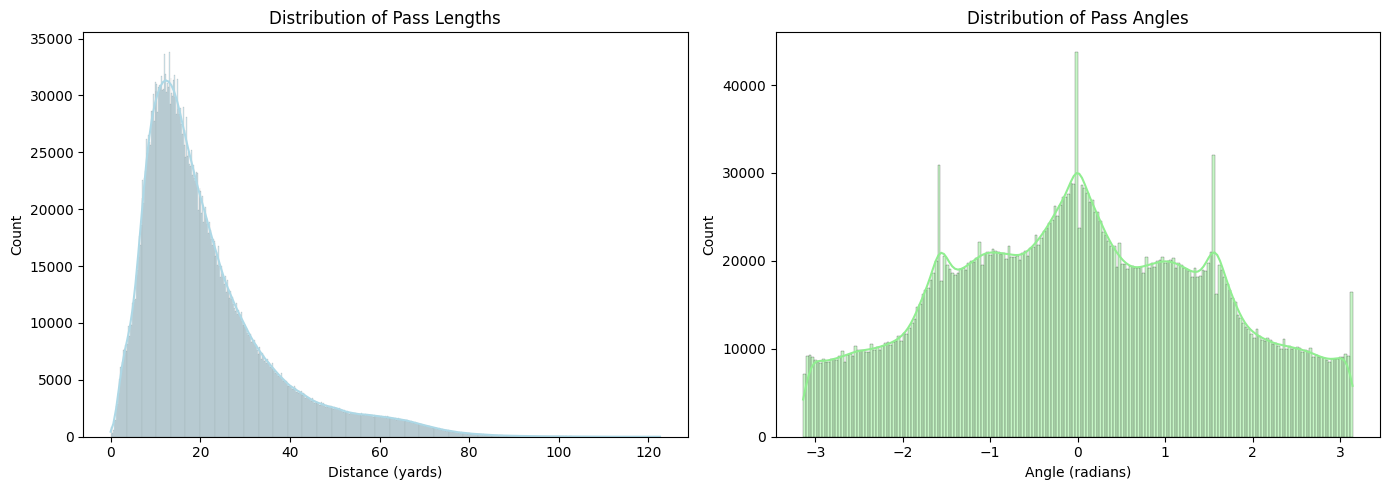

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Plot 1: Pass Length Distribution
plt.subplot(1, 2, 1)
sns.histplot(pass_features["pass_length"].to_list(), kde=True, color='lightblue')
plt.title("Distribution of Pass Lengths")
plt.xlabel("Distance (yards)")

# Plot 2: Pass Angle Distribution
# Note: 0 is horizontal, +/- 1.57 is vertical, +/- 3.14 is backward (radian angles where the length of the pitch is the horizontal axis)
plt.subplot(1, 2, 2)
sns.histplot(pass_features["pass_angle"].to_list(), kde=True, color='lightgreen')
plt.title("Distribution of Pass Angles")
plt.xlabel("Angle (radians)")

plt.tight_layout()
plt.show()

As expected, the pass length distribution is right-skewed with a long tail of longer passes. The majority of passes are short to medium range. 

The pass angle distribution shows peaks around 0 (horizontal passes) and +/- 1.57 (vertical passes), which is consistent with common passing patterns in soccer.

Next, we can explore categorical pass features like pass height and completion percentage to understand the success of different passes. This can be visualized using bar plots to compare pass completion success.

/var/folders/f1/6wqy11w93lzgkf_8n939yv040000gn/T/ipykernel_38964/3247687501.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=height_success.to_pandas(), x="pass_height", y="success_rate", palette="viridis")


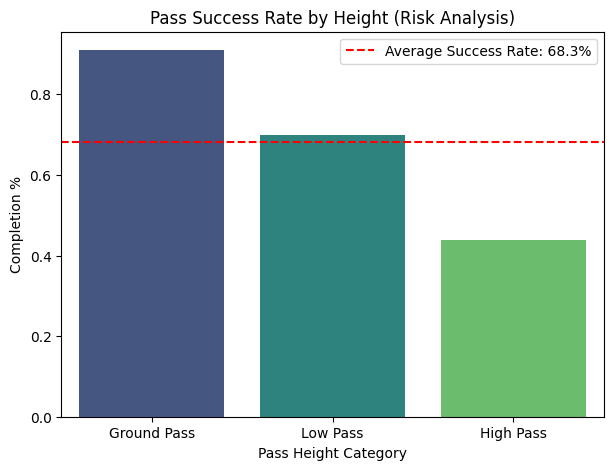

In [14]:
# Analyze relationship between Height and Success
height_success = (
    events.filter(pl.col("type") == "Pass")
    .with_columns(pl.col("pass_outcome").is_null().alias("is_success"))
    .group_by("pass_height")
    .agg([
        pl.len().alias("total"),
        pl.col("is_success").mean().alias("success_rate")
    ])
    .sort("success_rate", descending=True)
)

# Visualize Success Rate by Height
plt.figure(figsize=(7, 5))
sns.barplot(data=height_success.to_pandas(), x="pass_height", y="success_rate", palette="viridis")
avg_success = height_success["success_rate"].mean()
plt.axhline(avg_success, color='red', linestyle='--', label=f'Average Success Rate: {avg_success:.1%}')
plt.title("Pass Success Rate by Height (Risk Analysis)")
plt.ylabel("Completion %")
plt.xlabel("Pass Height Category")
plt.legend()
plt.show()

As expected, ground passes are more successful than low passes, which are more successful than high passes. This is consistent with the general understanding of soccer tactics, where ground passes are typically easier to control and complete compared to aerial passes. This visualization informs later feature engineering. Using the distribution of these pass types in a match we can establish a risk profile for teams. Are teams taking more risks with high passes throughout a match? 

Next, we can explore average pass length to understand if there are significant differences across teams. We can visualize this using a box plot to compare the distribution of pass lengths across teams. This can help identify if certain teams favor longer or shorter passes, which may indicate different tactical approaches. This was extended to a Kruskal-Wallis H-test to identify if there was statistical significance to the difference in average pass length across teams.

/var/folders/f1/6wqy11w93lzgkf_8n939yv040000gn/T/ipykernel_38964/1736109800.py:20: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  data=match_summary.filter(pl.col("team").is_in(top_teams)).to_pandas(),
/var/folders/f1/6wqy11w93lzgkf_8n939yv040000gn/T/ipykernel_38964/1736109800.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


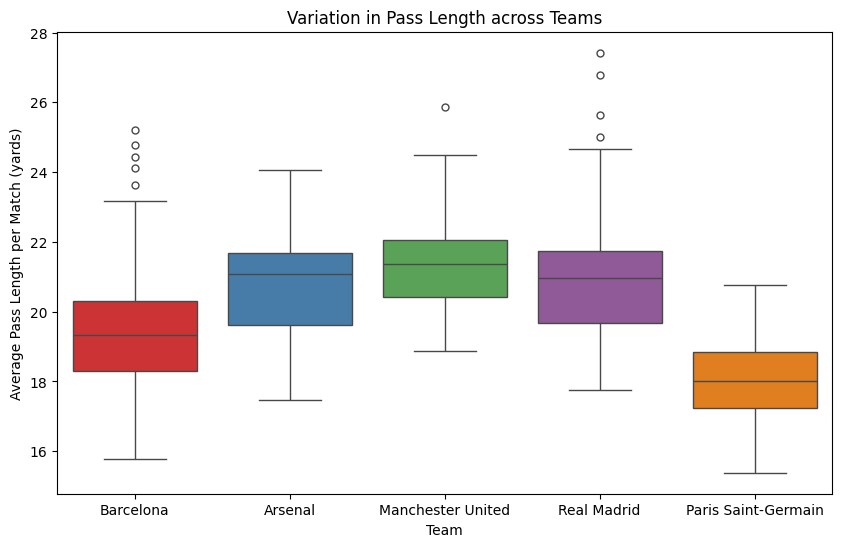

In [13]:
# Plot pass length variation across matches for top teams to explore play style diffences

match_summary = (
    events.filter(pl.col("type") == "Pass")
    .group_by(["match_id", "team"])
    .agg(pl.col("pass_length").mean().alias("avg_pass_length"))
)

# Select top 5 teams by number of matches
top_teams = (
    match_summary["team"]
    .value_counts()
    .sort("count", descending=True)
    .head(5)["team"]
)

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=match_summary.filter(pl.col("team").is_in(top_teams)).to_pandas(),
    x="team",
    y="avg_pass_length",
    palette="Set1",
    fliersize=5 # for outliers
)

plt.title("Variation in Pass Length across Teams", fontsize=12)
plt.ylabel("Average Pass Length per Match (yards)")
plt.xlabel("Team")
plt.show()

In [18]:
from scipy.stats import kruskal

groups = [
    match_passing_style.filter(pl.col("team") == team)["avg_length"].to_list() 
    for team in top_teams
]

# Use a Kruskal-Wallis H-test to determine if there are statistically significant differences in average pass length between the top teams.
# H0: The population medians of all 5 teams are equal (No difference in style).
# H1: At least one population median is different (Styles are statistically distinct).
stat, p = kruskal(*groups)

print("Kruskal-Wallis H-test")
print(f"Statistic: {stat:.4f}")
print(f"P-value: {p:.4e}")

if p < 0.05:
    print("\nResult: Reject the Null Hypothesis.")
    print("There is a statistically significant difference in the average pass length between these teams.")
else:
    print("\nResult: Fail to reject the Null Hypothesis.")
    print("The differences in passing length are not statistically significant at the 5% level.")

Kruskal-Wallis H-test
Statistic: 242.6888
P-value: 2.4456e-51

Result: Reject the Null Hypothesis.
There is a statistically significant difference in the average pass length between these teams.


The Kruskal-Wallis test indicates that teams are distinct in their passing styles but there is still a noticeable interquartile range overlap between teams. Teams likely adapt playstyles continuously and these differences can be present match to match or season to season. This is an interesting point to explore in future work.

Using the passing features explored in the EDA, we can engineer new features to capture team play style and risk profile. These features are aggregated into a match_passing_style vector that can be used for future analysis.

In [16]:
# Aggregate features at a match level to create a Playing Style for each team in each match. 
match_passing_style = (
    events.filter(pl.col("type") == "Pass")
    .with_columns([
        pl.col("pass_angle").abs().alias("abs_angle"), # Absolute angle to capture verticality regardless of direction
        (pl.col("pass_height") == "High Pass").alias("is_high"), # Risk ratio: % of high passes, which are riskier
        pl.col("pass_outcome").is_null().alias("is_success"), # Completion rate: % of complete passes (no negative outcome)
        pl.col("pass_cross").fill_null(False).alias("is_cross"), 
        pl.col("pass_switch").fill_null(False).alias("is_switch"),
        pl.col("pass_through_ball").fill_null(False).alias("is_through_ball")
    ])
    .group_by(["match_id", "team"])
    .agg([
        pl.col("pass_length").mean().alias("avg_length"), 
        pl.col("abs_angle").mean().alias("avg_verticality"), 
        pl.col("is_success").mean().alias("completion_rate"),
        pl.col("is_high").mean().alias("risk_ratio"),
        pl.col("is_cross").mean().alias("cross_rate"),
        pl.col("is_switch").mean().alias("switch_rate"),
        pl.col("is_through_ball").mean().alias("through_ball_rate"),
        pl.len().alias("pass_volume")
    ])
    # Filter for matches with a sufficient number of passes 
    .filter(pl.col("pass_volume") > 100)
    .sort("match_id")
)

print(f"Total Match-Team Data Points: {match_passing_style.height}")
with pl.Config(tbl_cols=-1):
    display(match_passing_style.head())

Total Match-Team Data Points: 6928


match_id,team,avg_length,avg_verticality,completion_rate,risk_ratio,cross_rate,switch_rate,through_ball_rate,pass_volume
i32,str,f32,f32,f64,f64,f64,f64,f64,u32
7298,"""Chelsea FCW""",20.896713,1.281081,0.756238,0.270633,0.024952,0.015355,0.005758,521
7298,"""Manchester City WFC""",20.564987,1.249025,0.751566,0.275574,0.022965,0.014614,0.002088,479
7430,"""North Carolina Courage""",20.810692,1.130006,0.677928,0.218468,0.022523,0.02027,0.0,444
7430,"""Washington Spirit""",22.055681,1.170845,0.691176,0.212185,0.021008,0.031513,0.0,476
7443,"""OL Reign""",21.494261,1.112311,0.632597,0.312155,0.013812,0.008287,0.0,362


In [23]:
# Descriptive Statistics for selected features (also check for missing values)
with pl.Config(tbl_cols=-1):
    display(match_passing_style.describe())

statistic,match_id,team,avg_length,avg_verticality,completion_rate,risk_ratio,cross_rate,switch_rate,through_ball_rate,pass_volume
str,f64,str,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",6928.0,"""6928""",6928.0,6928.0,6928.0,6928.0,6928.0,6928.0,6928.0,6928.0
"""null_count""",0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",2.9863e6,null,21.900457,1.232719,0.757936,0.241548,0.024191,0.02813,0.004951,488.995381
"""std""",1.5503e6,null,2.265499,0.118667,0.083121,0.091895,0.011016,0.011682,0.005491,141.512346
"""min""",7298.0,"""AC Ajaccio""",15.382031,0.741345,0.446154,0.039841,0.0,0.0,0.0,165.0
"""25%""",3.749434e6,null,20.375093,1.156204,0.704955,0.172867,0.016279,0.019886,0.0,387.0
"""50%""",3.825668e6,null,21.757011,1.239879,0.764298,0.233708,0.022989,0.027027,0.00339,470.0
"""75%""",3.879873e6,null,23.298672,1.318784,0.81883,0.301939,0.030738,0.034942,0.007212,574.0
"""max""",4.020846e6,"""Zambia Women's""",32.788956,1.525314,0.944149,0.633663,0.074597,0.091078,0.049608,1157.0


Before analysis, one additional step is to check for correlation between the engineered features to understand if there are any strong relationships that may impact later analysis. This can be visualized using a correlation heatmap to identify any highly correlated features that may need to be addressed in modeling.

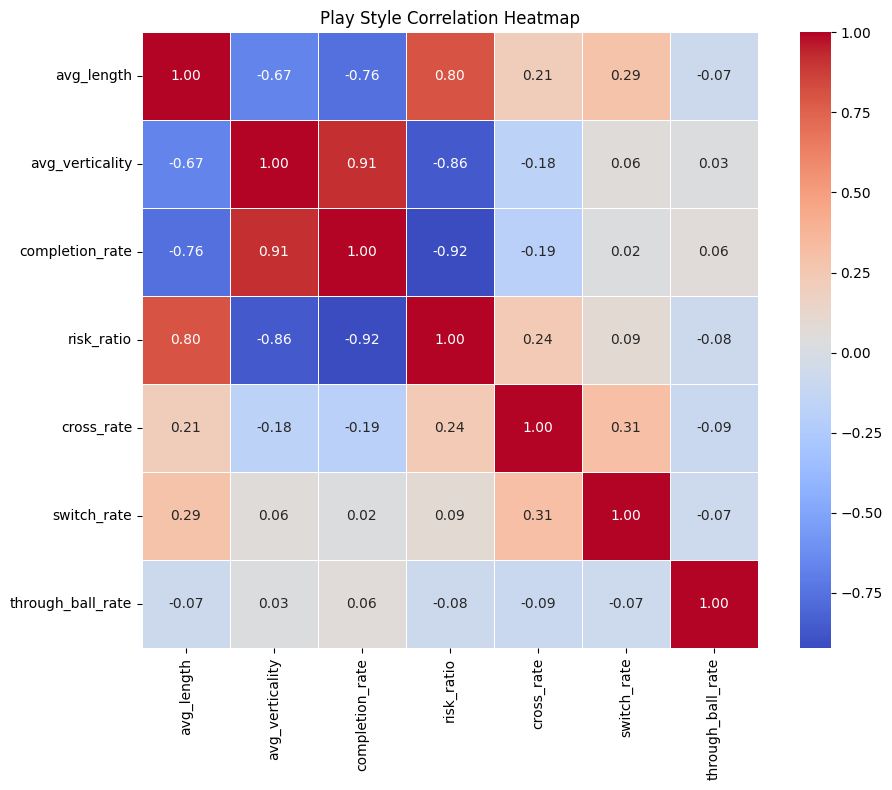

In [24]:
# Extract only tactical features for a correlation matrix
# Exclude 'match_id' and 'pass_volume' 
style_features = ["avg_length", "avg_verticality", "completion_rate", "risk_ratio", "cross_rate", "switch_rate", "through_ball_rate"]

corr_matrix = match_passing_style.select(style_features).to_pandas().corr()

plt.figure(figsize=(10, 8))

sns.heatmap(
    corr_matrix, 
    annot=True,         # Show the numerical correlation coefficient
    fmt=".2f",          # Round to 2 decimal places
    cmap='coolwarm',    # Red for positive, Blue for negative
    linewidths=0.5,      
    square=True          
)

plt.title("Play Style Correlation Heatmap", fontsize=12)
plt.tight_layout()
plt.show()

The correlation matrix above reveals certain relationships in the passing features. Namely:
- Directness vs Precision: There is a strong negative correlation between avg_length and completion_rate
- Risk Ratio: There is a strong negative coorelation of risk_ratio with completion_rate as discovered earlier
- Verticality: Interestingly, there is a strong correlation between avg_verticality and completion rate. Since avg_verticality uses the absolute value, this implies that passing up and down the field is correlated with higher completion rate as opposed to horizontal passes. This could be influenced by high crossing teams that have lower overall pass sucess.

### (Track 2) Soccer Analytics Dashboard Exploration

Following EDA, unsupervised learning and clustering of the match play style vectors will be used to determine tactical clusters. These clusters can be used to explore play styles and success across different seasons, leagues, and opponents.

The next steps would involve the deployment of a dashboard to Streamlit to visualize play styles using radar charts and heat maps. This could potentially be used by clubs to benchmark their tactical consistency against professional archetypes.

As a proof of concept, a radar chart is created below to compare the playing styles of different teams based on the match-level features we engineered in the previous section.

In [21]:
# Use the match-level playing style data to visualize play style using a radar chart to compare different teams.

import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Aggregate to team level
features = ["avg_length", "avg_verticality", "completion_rate", "risk_ratio", "cross_rate", "switch_rate", "through_ball_rate", "pass_volume"]

team_style = (
    match_passing_style.group_by("team")
    .agg([pl.col(f).mean() for f in features])
    .to_pandas()
)

# Normalize features to a 0-1 scale for the chart
scaler = MinMaxScaler()
team_style[features] = scaler.fit_transform(team_style[features])

# Plot function to compare teams on the radar chart
def plot_team_radar(teams, df):
    fig = go.Figure()

    for team in teams:
        team_data = df[df['team'] == team]
        if team_data.empty:
            continue
            
        fig.add_trace(go.Scatterpolar(
            r=team_data[features].values.flatten().tolist(),
            theta=[f.replace("_", " ").title() for f in features],
            fill='toself',
            name=team
        ))

    fig.update_layout(
        polar=dict(
            radialaxis=dict(visible=False, range=[0, 1])
        ),
        showlegend=True,
        title="Passing Style Comparison",
    )
    fig.show()

# Demonstrate with sample teams
compare_teams = ["Paris Saint-Germain", "Manchester United"]
plot_team_radar(compare_teams, team_style)

The Radar Chart above compares the average passing style of Paris Saint-Germain and Manchester United across the features we engineered. Each axis represents a different aspect of their passing style, normalized to a 0-1 scale for easy comparison. This visualization can help identify differences in play style, such as which team favors longer passes, more verticality, or higher risk passes. Clearly the profile of the two teams is distinct and they will likely fit into different clusters in future work.